# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [33]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from tabulate import tabulate
from sympy import Symbol, lambdify, sin

In [34]:
pd.set_option('display.float_format', lambda x: '%.4e' % x)

# Pomocnicze funkcje

## Dokładność przybliżenia

### Wykorzystane wskaźniki

Przyjmijmy następujące oznaczenia:

$F(x)$ - przybliżana funkcja (funkcja wzorcowa)

$f(x)$ - funkcja, która przybliża zadaną funkcję $F$

#### Norma z różnicy

$||F(x)-f(x)||$

In [35]:
def abs_diff(F, f, xs):
    return [abs(F(x) - f(x)) for x in xs]

#### Największa różnica

$max_k\{||F(x_k)-f(x_k)||\}$

In [36]:
def max_diff(F, f, xs):
    return max(abs_diff(F, f, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (F(x_i) - f(x_i))^2$

In [37]:
def sum_sq_diff(F, f, xs):
    return sum(d ** 2 for d in abs_diff(F, f, xs))

### Funkcja służąca do obliczania błędów

In [38]:
def calc_error(F, f, a, b, N=1000):
    xs = np.linspace(a, b, N)
    diffs = abs_diff(F, f, xs)
    return {
        'max': max(diffs),
        'sq': sum(x ** 2 for x in diffs)
    }

### Funkcja służąca do wypisywania błędów

In [39]:
def show_error(F, fs, a, b, N, *, prec=4):
    for f, label in fs:
        err = calc_error(F, f, a, b, N)
        print(tabulate([
                ('Największa bezwzględna różnica', err['max']),
                ('Suma kwadratów różnic      ', err['sq'])
            ], [
                label
            ], tablefmt='fancy_grid', floatfmt=f'.{prec}e')
        )

## Obliczanie wartości pochodnych funkcji 

### Badana funkcja

In [40]:
from math import e
x = Symbol('x')
g0 = e**(-2*sin(2*x))+2*sin(2*x)-1

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [41]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

### Rysowanie kilku funkcji na jednym wykresie

In [42]:
class Fn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[Fn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [43]:
class DetailedFn:
    def __init__(self, method, color='b', label='', args=(), kwargs={}):
        self.method = method
        self.color = color
        self.label = label
        self.args = args
        self.kwargs = kwargs

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[DetailedFn],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              nodes_color='#000',
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy przybliżenia',
              suptitle='Wykresy',
              show_errors_details=False,
              error_prec=4,
              max_derivative=0
             ):
    
    xs = nodes_calc_method(a, b, n)
    ys = np.vectorize(fn_obj.f)(xs) 
    ys_cp = ys
    
    if max_derivative:
        ys0 = ys
        ys = [list(ys)]
        gn = g0
        x_sym = Symbol('x')
        for i in range(1, max_derivative + 1):
            gn = gn.diff(x_sym)
            gn_call = lambdify(x_sym, gn)
            ys.append(list(map(lambda x: gn_call(x), xs)))
        ys = list(zip(*ys))
            
    W_objs = [Fn(obj.method(xs, ys, *obj.args, **obj.kwargs), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(suptitle, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
    # Compare to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys_cp, c=nodes_color)
    ax[0].grid(visible=True)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for i, W_obj in enumerate(W_objs):
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs, s=2, c=im_objs[i].color)
    ax[1].set_title(title_err)
    ax[1].grid(visible=True)
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    plt.show()
    
    if show_errors_details:
        show_error(fn_obj.f, [(W.f, W.label) for W in W_objs], a, b, N, prec=error_prec)

### Tworzenie nagłówka wykresu

In [44]:
def get_suptitle(n, m):
    nodes_text = 'węzłów'
    
    match n:
        case 1:
            nodes_text = 'węzeł'
        case 2 | 3 | 4:
            nodes_text = 'węzły'
            
    return f'Wielomian {m}. stopnia, {n} {nodes_text}'

# Wyznaczanie przybliżającej funkcji

## Badana funkcja

$F(x)=e^{-k\cdot sin(mx)} + k\cdot sin(mx) - 1$

In [45]:
F = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [46]:
a = -math.pi
b = 2 * math.pi
x = [a, b]

def g(x):
    k = 2
    m = 2
    return F(x, k, m)

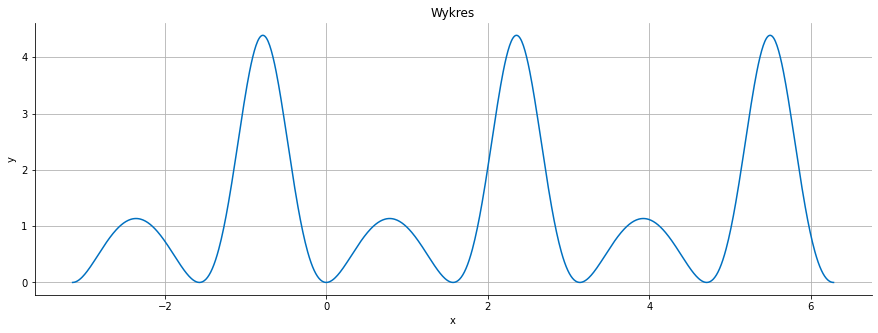

In [47]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01, color='#0070c0')

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [48]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

## Przybliżanie funkcji

### Metoda Lagrange'a

#### Algorytm

In [49]:
def lagrange(xs, ys):
    if len(xs) != len(ys):
        raise ValueError('A list of x values has different size than a list of y values')

    ms = []
    
    for xk in xs:
        m = 1
        for xi in xs:
            if xi != xk:
                m *= (xk - xi)
        ms.append(m)
    
    def f(x):
        y = 0
        
        for k, yk in enumerate(ys):
            d = 1
            for i, xi in enumerate(xs):
                if i == k: continue
                d *= (x - xi)
                
            y += d * yk / ms[k]
        
        return y
            
    return f

#### Wykresy

##### Wielomian $10.$ stopnia

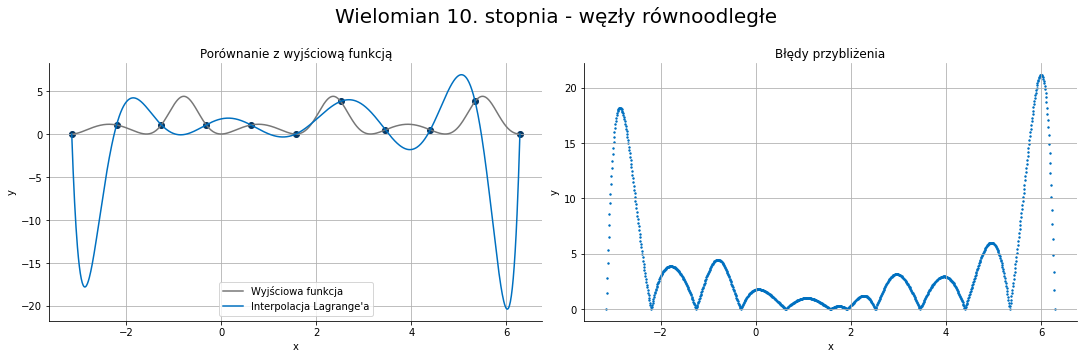

╒════════════════════════════════╤═══════════════════════════╕
│                                │   Interpolacja Lagrange'a │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                2.1170e+01 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                3.9901e+04 │
╘════════════════════════════════╧═══════════════════════════╛


In [50]:
n = 11

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(lagrange, '#0070c0', 'Interpolacja Lagrange\'a'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły równoodległe'
    )

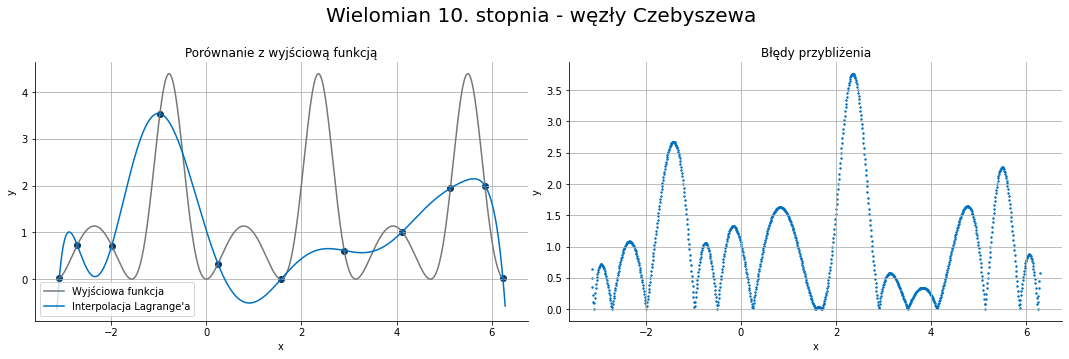

╒════════════════════════════════╤═══════════════════════════╕
│                                │   Interpolacja Lagrange'a │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                3.7634e+00 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                1.7503e+03 │
╘════════════════════════════════╧═══════════════════════════╛


In [51]:
n = 11

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(lagrange, '#0070c0', 'Interpolacja Lagrange\'a'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=chebyshev_nodes,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły Czebyszewa'
    )

##### Wielomian $186.$ stopnia

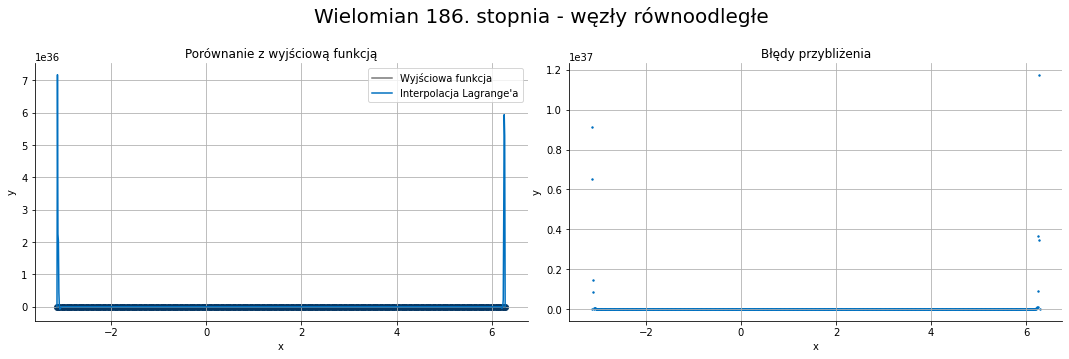

╒════════════════════════════════╤═══════════════════════════╕
│                                │   Interpolacja Lagrange'a │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                1.1752e+37 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                2.9262e+74 │
╘════════════════════════════════╧═══════════════════════════╛


In [52]:
n = 187

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(lagrange, '#0070c0', 'Interpolacja Lagrange\'a'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły równoodległe'
    )

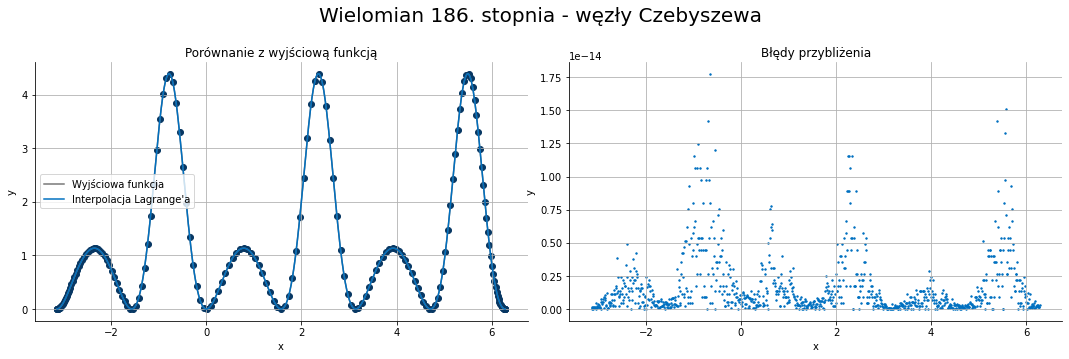

╒════════════════════════════════╤═══════════════════════════╕
│                                │   Interpolacja Lagrange'a │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                1.7764e-14 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                7.7862e-27 │
╘════════════════════════════════╧═══════════════════════════╛


In [53]:
n = 187

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(lagrange, '#0070c0', 'Interpolacja Lagrange\'a'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=chebyshev_nodes,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły Czebyszewa'
    )

### Metoda Newtona

In [54]:
def newton(xs, ys):
    if len(xs) != len(ys):
        raise ValueError('A list of x values has different size than a list of y values')
        
    n = len(xs)
    bs = list(ys)
    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            bs[i] = (bs[i] - bs[i - 1]) / (xs[i] - xs[i - j])
            
    def f(x):
        x_diffs = [1] + [x - xs[i] for i in range(n - 1)]
        
        y = 0
        x_coeff = 1
        for bi, x_diff in zip(bs, x_diffs):
            x_coeff *= x_diff
            y += bi * x_coeff
            
        return y
            
    return f

#### Wykresy

##### Wielomian

##### Wielomian $10.$ stopnia

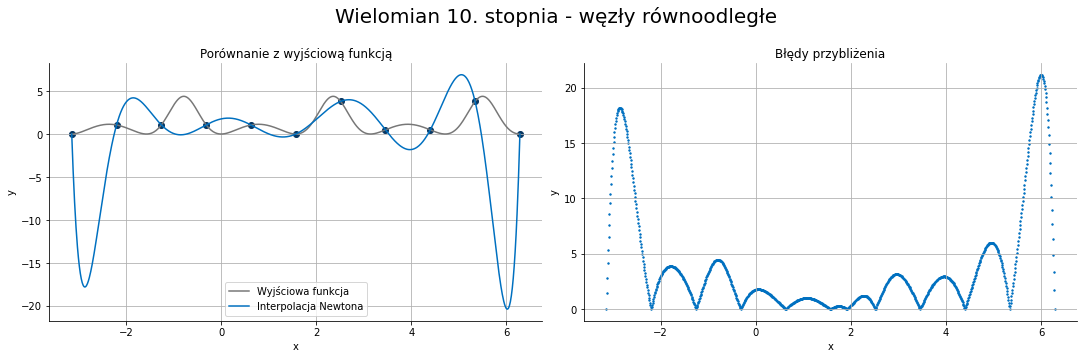

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             2.1170e+01 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             3.9901e+04 │
╘════════════════════════════════╧════════════════════════╛


In [55]:
n = 11

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(newton, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły równoodległe'
    )

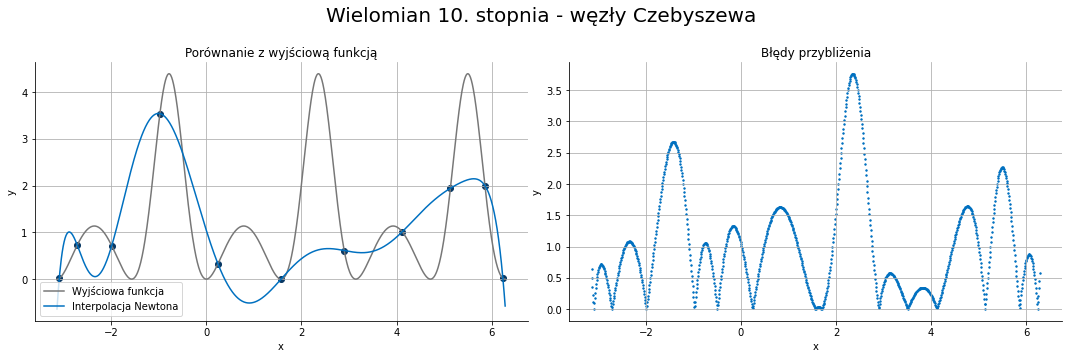

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             3.7634e+00 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             1.7503e+03 │
╘════════════════════════════════╧════════════════════════╛


In [56]:
n = 11

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(newton, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=chebyshev_nodes,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły Czebyszewa'
    )

##### Wielomian $38.$ stopnia

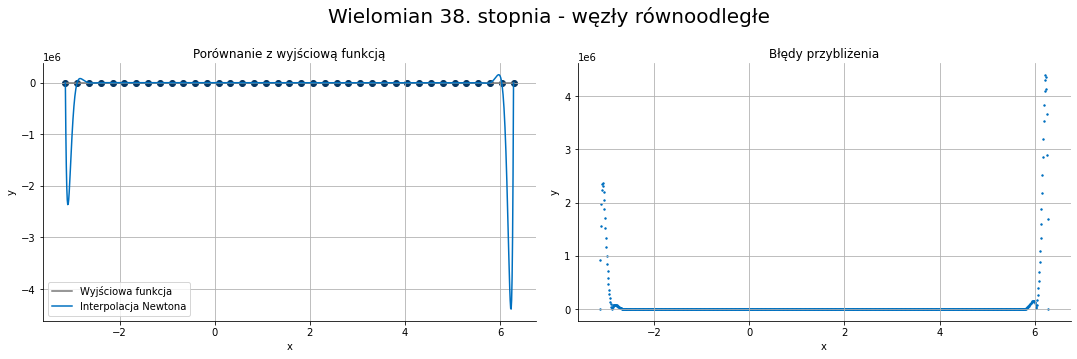

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             4.3988e+06 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             2.3577e+14 │
╘════════════════════════════════╧════════════════════════╛


In [57]:
n = 39

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(newton, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły równoodległe'
    )

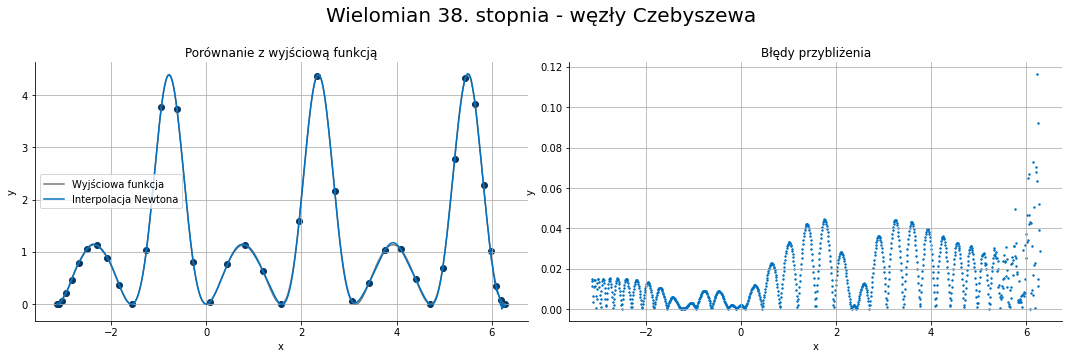

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             1.1657e-01 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             4.3465e-01 │
╘════════════════════════════════╧════════════════════════╛


In [58]:
n = 39

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(newton, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=chebyshev_nodes,
        nodes_color='#073763',
        suptitle=f'Wielomian {n - 1}. stopnia - węzły Czebyszewa'
    )

### Interpolacja Hermite'a

In [59]:
def memoized(fn):
    cache = {}

    def inner(arg):
        if arg not in cache:
            cache[arg] = fn(arg)
        return cache[arg]
        
    return inner

@memoized
def factorial(n):
    if n in {0, 1}: return 1
    return n * factorial(n - 1)

def hermite(xs: list[int], ys: list[list[int]]):
    if len(xs) != len(ys):
        raise ValueError('The length of the xs list is different from from the length of the ys list')
    if not all(len(y_list) for y_list in ys):
        raise ValueError('Lists of function values and derivatives must be not empty')
    
    ms = [len(y_list) for y_list in ys]
    m = sum(ms) # Total number of coefficients
    n = m - 1  # Degree of a polynomial
    
    xs_ = []
    for i in range(len(xs)):
        xs_.extend([xs[i]] * ms[i])
    
    # Create a matrix of coefficients
    bs = [[None] * m for _ in range(m)]
    
    # Fill a matrix with known values
    i = 0
    for y_list in ys:
        for j in range(len(y_list)):
            for k in range(j + 1):
                bs[i][k] = y_list[k] / factorial(k)
            i += 1
            
    # Fill the remaining triangular part of a matrix
    for j in range(1, m):
        for i in range(j, m):
            if bs[i][j] is not None: 
                continue
            bs[i][j] = (bs[i][j - 1] - bs[i - 1][j - 1]) / (xs_[i] - xs_[i - j])
            
    # Rewrite coefficients to the linear array
    bs_ = [bs[i][i] for i in range(m)]
    
    # Create interpolating function
    def f(x):
        x_diffs = [x - xi for xi in xs]

        y = bs_[0]
        Pl = 1
        deg = 0  # Current Pl polynomial degree
        for i, mi in enumerate(ms):
            for _ in range(mi):
                deg += 1
                Pl *= x_diffs[i]
                y += bs_[deg] * Pl
                if deg == n:
                    return y
                
    return f

#### Wykresy

##### Wielomian $15.$ stopnia

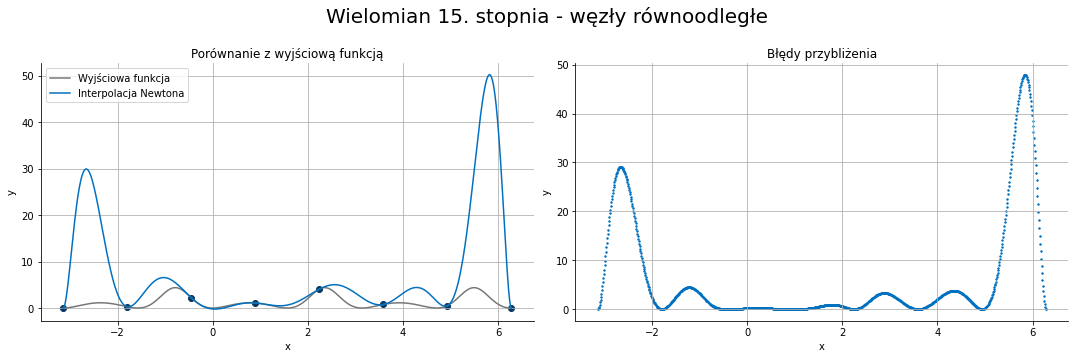

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             4.7933e+01 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             1.5781e+05 │
╘════════════════════════════════╧════════════════════════╛


In [60]:
n = 8

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(hermite, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        max_derivative=1,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {2 * n - 1}. stopnia - węzły równoodległe'
    )

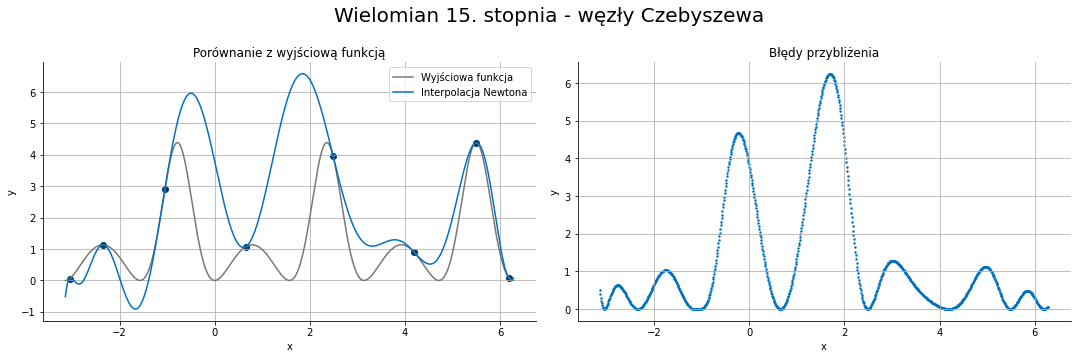

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             6.2510e+00 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             4.3536e+03 │
╘════════════════════════════════╧════════════════════════╛


In [61]:
n = 8

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(hermite, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        max_derivative=1,
        nodes_calc_method=chebyshev_nodes,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {2 * n - 1}. stopnia - węzły Czebyszewa'
    )

##### Wielomian $41.$ stopnia

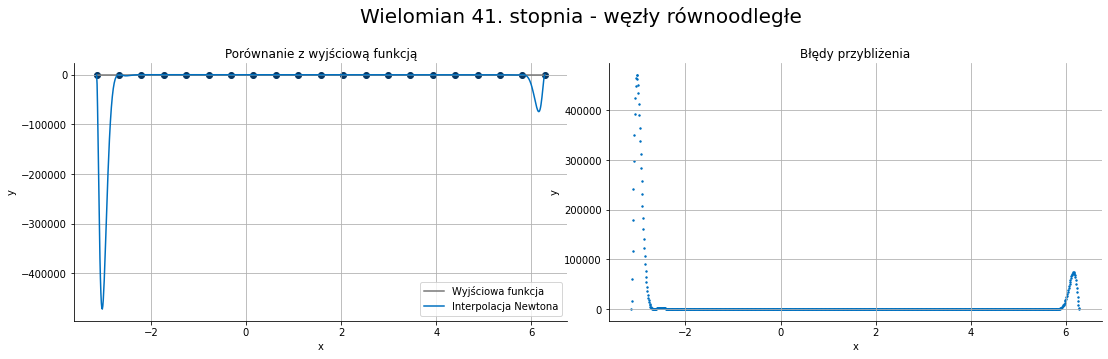

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             4.7154e+05 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             3.2498e+12 │
╘════════════════════════════════╧════════════════════════╛


In [62]:
n = 21

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(hermite, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        max_derivative=1,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {2 * n - 1}. stopnia - węzły równoodległe'
    )

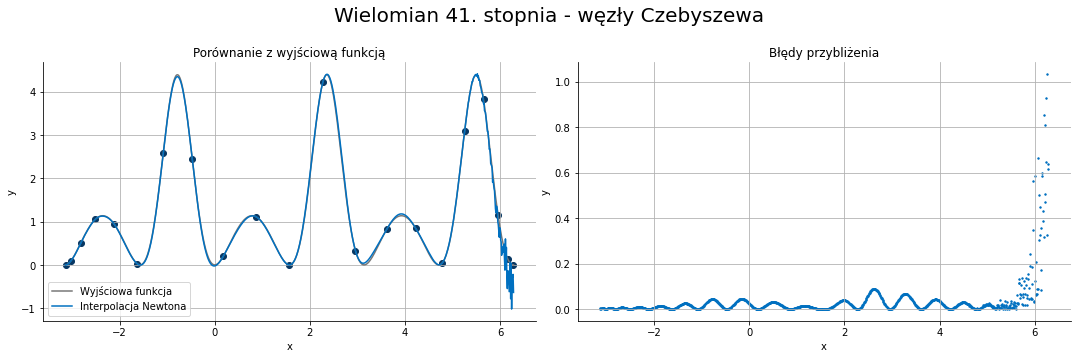

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             1.0341e+00 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             9.3135e+00 │
╘════════════════════════════════╧════════════════════════╛


In [63]:
n = 21

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(hermite, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        max_derivative=1,
        nodes_calc_method=chebyshev_nodes,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {2 * n - 1}. stopnia - węzły Czebyszewa'
    )

##### Najlepszy wielomian

###### float

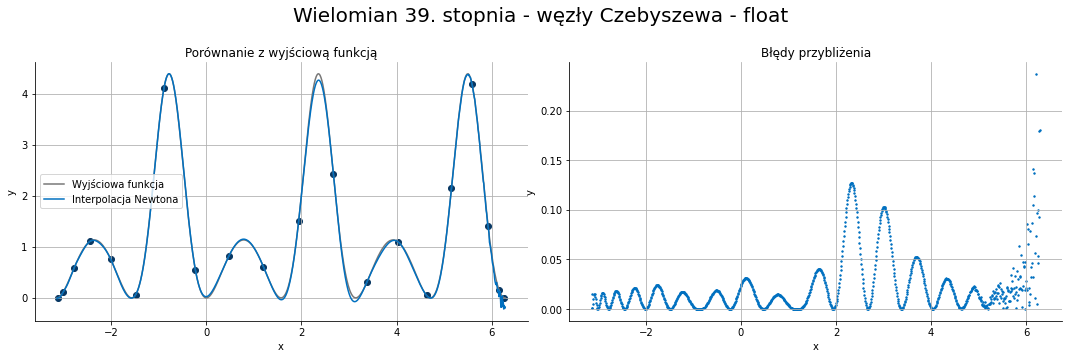

╒════════════════════════════════╤════════════════════════╕
│                                │   Interpolacja Newtona │
╞════════════════════════════════╪════════════════════════╡
│ Największa bezwzględna różnica │             2.3715e-01 │
├────────────────────────────────┼────────────────────────┤
│ Suma kwadratów różnic          │             1.2809e+00 │
╘════════════════════════════════╧════════════════════════╛


In [64]:
n = 20

rich_plot(
        Fn(g, "#777", "Wyjściowa funkcja"), 
        [
            DetailedFn(hermite, '#0070c0', 'Interpolacja Newtona'),
        ], 
        a, b, n,
        max_derivative=1,
        nodes_calc_method=chebyshev_nodes,
        show_errors_details=True,
        nodes_color='#073763',
        suptitle=f'Wielomian {2 * n - 1}. stopnia - węzły Czebyszewa - float'
    )

### Funkcje sklejane 2. stopnia

In [65]:
import enum

class QuadBoundCond(enum.Enum): 
    NaturalSpline = 0  # Free Bundary
    ClampedBoundary = 1
    
class QuadraticSpline:
    def __init__(self, xs, ys, *, boundary_condition=QuadBoundCond.NaturalSpline):
        self.n = n = len(ys)  # The number of nodes
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = max(0, min(self.search_range_idx(x), self.n - 2))
        return self.fns[i](x)
    
    def γ(self, i):
        return (self.ys[i] - self.ys[i - 1]) / (self.xs[i] - self.xs[i - 1])
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
    
    def __solve(self):
        match self.bc:
            case QuadBoundCond.NaturalSpline:
                self.__solve_with_natural_spline()
            case QuadBoundCond.ClampedBoundary:
                self.__solve_with_clamped_boundary()
        
    def __solve_with_natural_spline(self):
        n = self.n
        a_list = []
        b_list = [0]
        c_list = self.ys
        
        self.__calc_coefficients(a_list, b_list)
        self.__calc_functions(a_list, b_list, c_list)

    def __solve_with_clamped_boundary(self):
        n = self.n
        a_list = []
        # f'(x1) = f[x0, x1] = (f(x1) - f(x0)) / (x1 - x0) = (y1 - y0) / (x1 - x0)
        b_list = [(self.ys[1] - self.ys[0]) / (self.xs[1] - self.xs[0])]  
        c_list = self.ys
        
        self.__calc_coefficients(a_list, b_list)
        self.__calc_functions(a_list, b_list, c_list)
        
    def __calc_coefficients(self, a_list, b_list):
        for i in range(1, n):
            b_list.append(2 * self.γ(i) - b_list[-1])

        for i in range(n - 1):
            a_list.append((b_list[i + 1] - b_list[i]) / (2 * (self.xs[i + 1] - self.xs[i])))
        
    def __calc_functions(self, a_list, b_list, c_list):
        def s(i):
            a = a_list[i]
            b = b_list[i]
            c = c_list[i]
            return lambda x: a * (x - self.xs[i]) ** 2 + b * (x - self.xs[i]) + c
        
        for i in range(self.n - 1):
            self.fns.append(s(i))

#### Wykresy

##### Dla $35$ węzłów

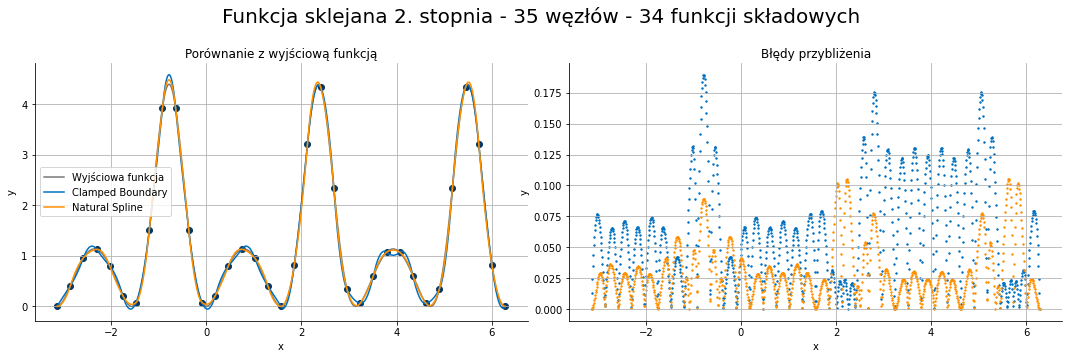

╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         1.8954e-01 │
├────────────────────────────────┼────────────────────┤
│ Suma kwadratów różnic          │         5.5058e+00 │
╘════════════════════════════════╧════════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       1.0527e-01 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.4328e+00 │
╘════════════════════════════════╧══════════════════╛


In [66]:
n = 35

rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(QuadraticSpline, '#0070c0', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        DetailedFn(QuadraticSpline, '#ff9000', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 2. stopnia - {n} węzłów - {n - 1} funkcji składowych'
)

##### Dla $100$ węzłów

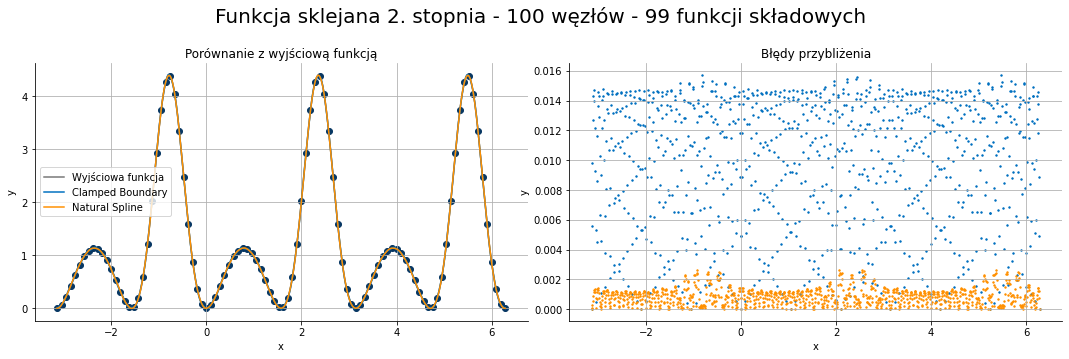

╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         1.5742e-02 │
├────────────────────────────────┼────────────────────┤
│ Suma kwadratów różnic          │         1.1502e-01 │
╘════════════════════════════════╧════════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       2.6358e-03 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.0548e-03 │
╘════════════════════════════════╧══════════════════╛


In [67]:
n = 100

rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(QuadraticSpline, '#0070c0', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        DetailedFn(QuadraticSpline, '#ff9000', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 2. stopnia - {n} węzłów - {n - 1} funkcji składowych'
)

##### Dla $10000$ węzłów

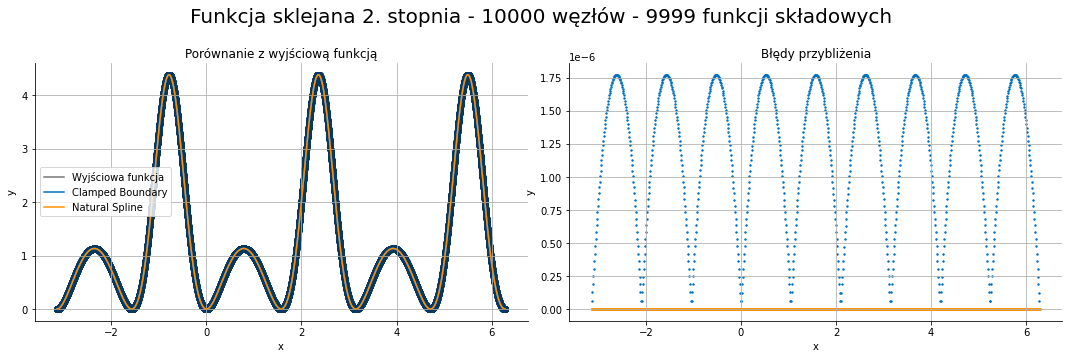

╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         1.7734e-06 │
├────────────────────────────────┼────────────────────┤
│ Suma kwadratów różnic          │         1.6760e-09 │
╘════════════════════════════════╧════════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       1.7872e-09 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       7.4891e-16 │
╘════════════════════════════════╧══════════════════╛


In [68]:
n = 10000

rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(QuadraticSpline, '#0070c0', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        DetailedFn(QuadraticSpline, '#ff9000', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 2. stopnia - {n} węzłów - {n - 1} funkcji składowych'
)

### Funkcje sklejane 3. stopnia

In [69]:
from pprint import pprint as pp
import enum


def det_(A, B=None, substitute_idx=None):
    n = len(A)
    res = 0
    diags = np.ones(3)
    
    for i in range(n):
        if i > 0: diags[0] *= A[i, 0] if i - 1 != substitute_idx else B[i]
        diags[1] *= A[i, 1] if i != substitute_idx else B[i]
        if i < n - 1: diags[2] *= A[i, 2] if i + 1 != substitute_idx else B[i]

    return sum(diags)

def cramer(A, B):
    n = len(A)
    W = det_(A)
    W_ = [det_(A, B, i) for i in range(n)]  # A list of determinants
    return [W_[i] / W for i in range(n)]

def gauss(A, B):
    A = np.array(A, float)
    B = np.array(B, float)
    n = len(A)
    X = np.zeros(n, float)
    
    # Elimination
    for r in range(n - 1):
        if A[r + 1, 0] == 0: continue
        factor = A[r, 1] / A[r + 1, 0]  # main diagonal has idx 1
        for c in range(3 if r < n - 1 else 2):
            A[r + 1, c] = (A[r, c + 1] if c < 2 else 0) - A[r + 1, c] * factor
        B[r + 1] = B[r] - B[r + 1] * factor

    # Back substitution
    X[n - 1] = B[n - 1] / A[n - 1, 1]
    for r in range(n - 2, -1, -1):
        X[r] = (B[r] - A[r, 2] * X[r + 1]) / A[r, 1]

    return X

class CubicBoundCond(enum.Enum):
    CubicFunction = 0
    NaturalSpline = 1 # Free boundary
    ClampedBoundary = 2
    
class CubicSpline:
    def __init__(self, xs, ys, *, boundary_condition=CubicBoundCond.NaturalSpline):
        self.n = n = len(ys)
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = max(0, min(self.search_range_idx(x), self.n - 2))
        return self.fns[i](x)
        
    def h(self, i):
        return self.xs[i + 1] - self.xs[i]
    
    def Δ(self, i):
        return (self.ys[i + 1] - self.ys[i]) / self.h(i)
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
        
    def __solve(self):
        match self.bc:
            case CubicBoundCond.CubicFunction:
                return self.__solve_with_cubic_function()
            case CubicBoundCond.NaturalSpline:
                return self.__solve_with_natural_spline()
            case CubicBoundCond.ClampedBoundary:
                return self.__solve_with_clamped_boundary()
        
    def __solve_with_cubic_function(self):
        n = self.n
        h = self.h
        A = np.zeros((n, 3))
        B = np.zeros(n)
        
        self.__fill_middle_rows(A, B, 0)
        
        ### Apply boundary conditions
        start_xs = self.xs[:4]
        start_ys = self.ys[:4]
        end_xs = self.xs[-4:]
        end_ys = self.ys[-4:]
        Δs1 = self.__differential_quotients(start_xs, start_ys)
        Δs2 = self.__differential_quotients(end_xs, end_ys)
        
        # The first row
        A[0, 1] = -h(0)
        A[0, 2] = h(0)
        B[0] = h(0) ** 2 * Δs1[3]
        
        # The last row
        A[n - 1, 0] = h(n - 2)
        A[n - 1, 1] = -h(n - 2)
        B[n - 1] = -h(n - 2) ** 2 * Δs2[3]
            
        σs = gauss(A, B)  # Use modified Gauss Elimination algorithm to solve a system of equations
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __solve_with_natural_spline(self):
        n = self.n
        A = np.zeros((n - 2, 3))
        B = np.zeros(n - 2)
        
        self.__fill_middle_rows(A, B, -1)
        A[0, 0] = A[-1, -1] = 0
    
        σs = [0, *gauss(A, B), 0]  # Use modified Gauss Elimination algorithm to solve a system of equations
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __solve_with_clamped_boundary(self):
        n = self.n
        h = self.h
        Δ = self.Δ
        A = np.zeros((n, 3))
        B = np.zeros(n)
        
        self.__fill_middle_rows(A, B, 0)
        
        ### Apply boundary conditions
        A[n - 1, 0] = A[0, 1] = 2
        A[n - 1, 1] = A[0, 2] = 1
        B[n - 1] = B[0] = 0
        
        σs = gauss(A, B)  # Use modified Gauss Elimination algorithm to solve a system of equations
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __fill_middle_rows(self, A, B, offset):
        for i in range(1, self.n - 1):
            A[i + offset, 0] = self.h(i - 1)
            A[i + offset, 1] = 2 * (self.h(i - 1) + self.h(i))
            A[i + offset, 2] = self.h(i)
            B[i + offset] = self.Δ(i) - self.Δ(i - 1)
        
    def __calc_coefficients(self, σs):
        a_list = []
        b_list = []
        c_list = []
        d_list = self.ys
        
        for i in range(self.n - 1):
            a_list.append((σs[i + 1] - σs[i]) / self.h(i))
            b_list.append(3 * σs[i])
            c_list.append((self.ys[i + 1] - self.ys[i]) / self.h(i) - self.h(i) * (σs[i + 1] + 2 * σs[i]))
        
        return a_list, b_list, c_list, d_list
        
    def __calc_functions(self, a_list, b_list, c_list, d_list):
        for i in range(self.n - 1):
            def s(i):
                a = a_list[i]
                b = b_list[i]
                c = c_list[i]
                d = d_list[i]
            
                def f(x):
                    diff = x - self.xs[i]
                    return a * diff**3 + b * diff**2 + c * diff + d
                return f
            
            self.fns.append(s(i))

    @staticmethod
    def __differential_quotients(xs, ys):
        n = len(xs)
        Δs = list(ys)
        
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                Δs[i] = (Δs[i] - Δs[i - 1]) / (xs[i] - xs[i - j])
                
        return Δs

#### Wykresy

##### Dla $15$ węzłów

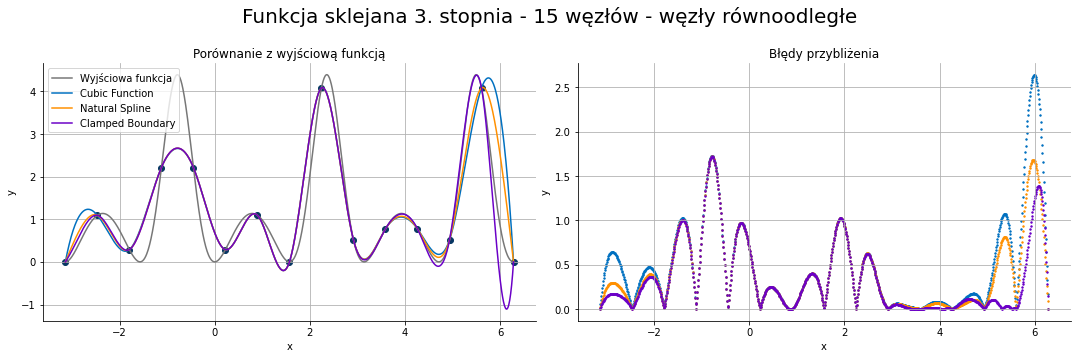

╒════════════════════════════════╤══════════════════╕
│                                │   Cubic Function │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       2.6432e+00 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       5.3490e+02 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       1.7234e+00 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       3.5314e+02 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         1.7212e+00 │
├───────────────────

In [70]:
n = 15


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(CubicSpline, '#0070c0', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FF9000', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#6B00C7', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 3. stopnia - {n} węzłów - węzły równoodległe'
)

##### Dla $25$ węzłów

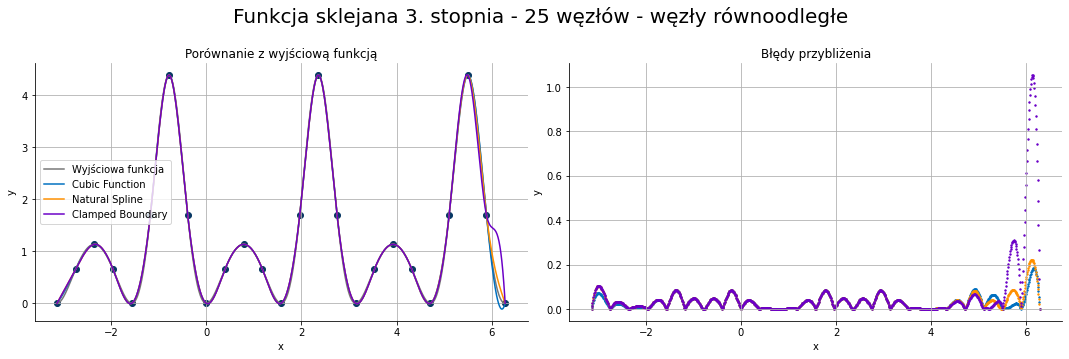

╒════════════════════════════════╤══════════════════╕
│                                │   Cubic Function │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       1.8405e-01 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.9281e+00 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       2.2242e-01 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       2.5049e+00 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         1.0557e+00 │
├───────────────────

In [71]:
n = 25


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(CubicSpline, '#0070c0', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FF9000', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#6B00C7', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 3. stopnia - {n} węzłów - węzły równoodległe'
)

##### Dla $50$ węzłów

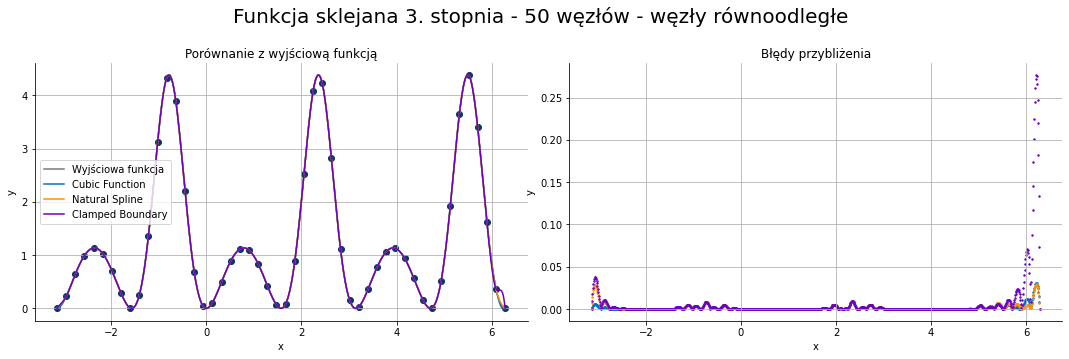

╒════════════════════════════════╤══════════════════╕
│                                │   Cubic Function │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       3.1019e-02 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.5379e-02 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       2.9274e-02 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       2.1664e-02 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         2.7704e-01 │
├───────────────────

In [72]:
n = 50


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(CubicSpline, '#0070c0', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FF9000', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#6B00C7', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 3. stopnia - {n} węzłów - węzły równoodległe'
)

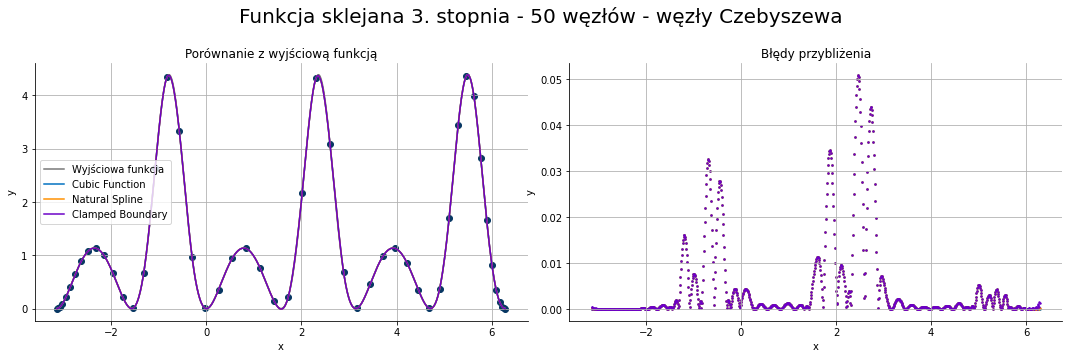

╒════════════════════════════════╤══════════════════╕
│                                │   Cubic Function │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       5.1018e-02 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.1640e-01 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤══════════════════╕
│                                │   Natural Spline │
╞════════════════════════════════╪══════════════════╡
│ Największa bezwzględna różnica │       5.1018e-02 │
├────────────────────────────────┼──────────────────┤
│ Suma kwadratów różnic          │       1.1640e-01 │
╘════════════════════════════════╧══════════════════╛
╒════════════════════════════════╤════════════════════╕
│                                │   Clamped Boundary │
╞════════════════════════════════╪════════════════════╡
│ Największa bezwzględna różnica │         5.1018e-02 │
├───────────────────

In [73]:
n = 50


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(CubicSpline, '#0070c0', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FF9000', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#6B00C7', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_calc_method=chebyshev_nodes,
    nodes_color='#073763',
    suptitle=f'Funkcja sklejana 3. stopnia - {n} węzłów - węzły Czebyszewa'
)

### Porównanie funkcji sklejanych 2. i 3. stopnia

#### Dla $20$ węzłów

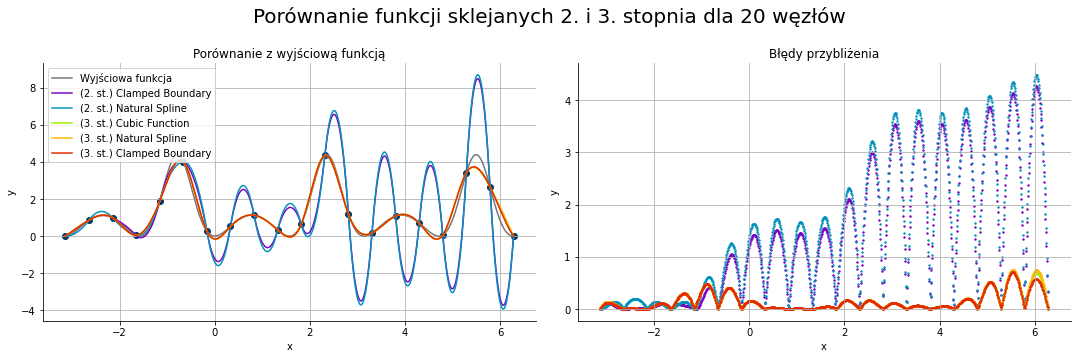

╒════════════════════════════════╤═════════════════════════════╕
│                                │   (2. st.) Clamped Boundary │
╞════════════════════════════════╪═════════════════════════════╡
│ Największa bezwzględna różnica │                  4.2678e+00 │
├────────────────────────────────┼─────────────────────────────┤
│ Suma kwadratów różnic          │                  3.5091e+03 │
╘════════════════════════════════╧═════════════════════════════╛
╒════════════════════════════════╤═══════════════════════════╕
│                                │   (2. st.) Natural Spline │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                4.4833e+00 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                4.0009e+03 │
╘════════════════════════════════╧═══════════════════════════╛
╒════════════════════════════════╤═══════════════════════════╕
│                                │   (3. 

In [76]:
n = 20


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        DetailedFn(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Porównanie funkcji sklejanych 2. i 3. stopnia dla {n} węzłów'
)

#### Dla $100$ węzłów

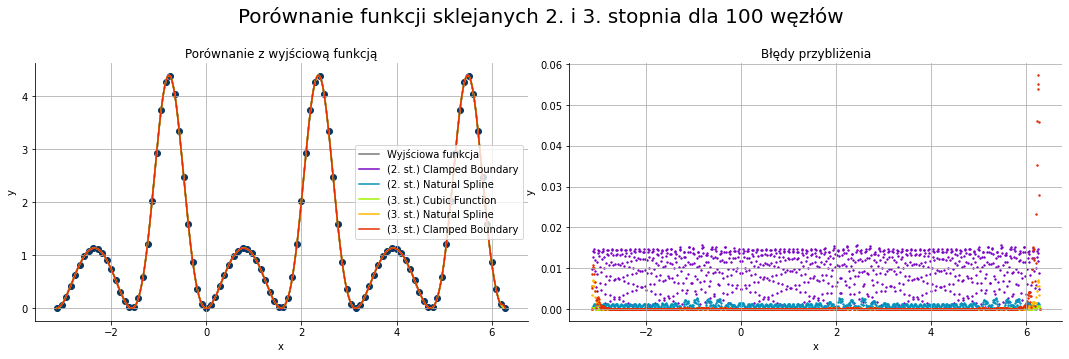

╒════════════════════════════════╤═════════════════════════════╕
│                                │   (2. st.) Clamped Boundary │
╞════════════════════════════════╪═════════════════════════════╡
│ Największa bezwzględna różnica │                  1.5742e-02 │
├────────────────────────────────┼─────────────────────────────┤
│ Suma kwadratów różnic          │                  1.1502e-01 │
╘════════════════════════════════╧═════════════════════════════╛
╒════════════════════════════════╤═══════════════════════════╕
│                                │   (2. st.) Natural Spline │
╞════════════════════════════════╪═══════════════════════════╡
│ Największa bezwzględna różnica │                2.6358e-03 │
├────────────────────────────────┼───────────────────────────┤
│ Suma kwadratów różnic          │                1.0548e-03 │
╘════════════════════════════════╧═══════════════════════════╛
╒════════════════════════════════╤═══════════════════════════╕
│                                │   (3. 

In [75]:
n = 100


rich_plot(
    Fn(g, "#777", "Wyjściowa funkcja"), 
    [
        DetailedFn(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        DetailedFn(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        DetailedFn(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        DetailedFn(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_color='#073763',
    suptitle=f'Porównanie funkcji sklejanych 2. i 3. stopnia dla {n} węzłów'
)